Hunter Bennett | Glass Lab | Brain Aging Project | 27 Feb 2021

Goal of this analysis is to compare promoter acetylation in 4 month microglia to gene expression in 4 month microglia as a way of justifying the use of promoter acetylation as a proxy for gene expression.

Things to add:
* Try calculating correlations the way inge does it where we look at pairwise correlations for intra-cell type versus pairwise correlations for non-cell type

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

### Set working paths

In [2]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/brain_aging/results/04_Young_Cell_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Read in color scheme dictionary

In [3]:
hex_dict={}
rgb_dict={}
for line in open('/home/h1bennet/brain_aging/data/brain_aging_color_table.txt','r'):
    split = line.strip().replace('\ufeff','').split('\t')
    # split2 = split[1]
    hex_dict[split[0]] = split[1]
    rgb_dict[split[0]] = split[2]    

# Read in annotated promoters

Mouse promoters

In [39]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_promoters.txt')

# # try with dropped sample
dropsamp = ['XXX']
drop_files = mat.columns[mat.columns.str.contains('|'.join(dropsamp))]
df = df.drop(drop_files, axis=1)

# pull gene name for merging - capitalize to match human gene names
df = df.set_index('Gene Name')
df.index = df.index.str.upper()

# extract just tag counts
mat = df.loc[:, df.columns.str.contains('Brain_MPSIIIA')]

In [40]:
groups = ['olig2_4month', 'neun_4month', 'pu1_4month', 'sox9_4month']
columns = [[0,1,2],
           [3,4,5,6,7],
           [8,9,10],
           [11,12]]

avg_tss = {}

for group, col in zip(groups, columns):
    avg_tss[group] = mat.iloc[:, col].mean(1)
    
avg_tss_df = pd.DataFrame(avg_tss)

Human promoters

In [41]:
# import annotation file
hum_df, hum_mat = read_annotated_peaks(
    '/gpfs/data01/glasslab/home/h1bennet/brain_aging/data/annotated_peaks_tss_with_pooled_tagdirs_H3K27ac_norm.txt')

# # try with dropped sample
dropsamp = ['XXX']
drop_files = hum_mat.columns[hum_mat.columns.str.contains('|'.join(dropsamp))]

hum_df = hum_df.drop(drop_files, axis=1)
hum_mat = hum_mat.drop(drop_files, axis=1)

# pull gene name for merging - capitalize to match human gene names
hum_df = hum_df.set_index('Gene Name')

# extract matrix
hum_mat = hum_df.loc[:, hum_df.columns.str.contains('H3K27ac')]

# Compare tss values for genes across species
____
Since we are comparing analagous genes we can't match based on refseq ID, instead we will need to match based on gene name, and thus collapse expression down to one per gene, pick based on highest level of acetylation.

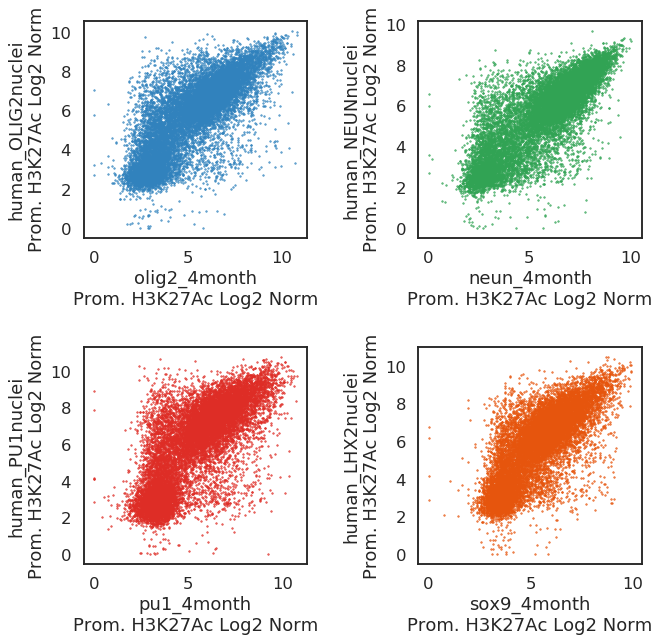

In [81]:
corr={}

mus_cols = ['olig2_4month',
            'neun_4month',
            'pu1_4month',
            'sox9_4month']
hum_cols = ['/data/hg19/Nuclei/merged_tag_dir/human_OLIG2nuclei_H3K27ac_epilepsy_pooled_hg19/',
            '/data/hg19/Nuclei/merged_tag_dir/human_NEUNnuclei_H3K27ac_epilepsy_pooled_hg19/',
            '/data/hg19/Nuclei/merged_tag_dir/human_PU1nuclei_H3K27ac_epilepsy_pooled_hg19/',
            '/data/hg19/Nuclei/merged_tag_dir/human_LHX2nuclei_H3K27ac_epilepsy_pooled_hg19/']

fig, axs = plt.subplots(2,2,figsize=(10,10))
plt.subplots_adjust(hspace=0.5,
                    wspace=0.5)
for i, j, ax in zip(mus_cols, hum_cols, axs.reshape(-1)):
    
    
    # sort values highest first, this way the first entry of any gene
    # will come first in the list
    mus_filt = avg_tss_df[i].sort_values(ascending=False)
    # filter duplicates, keeping the first instance which is the highest expressed
    mus_filt = mus_filt[~mus_filt.index.duplicated()]
    
    # sort values highest first, this way the first entry of any gene
    # will come first in the list
    hum_filt = hum_mat[j].sort_values(ascending=False)
    # filter duplicates, keeping the first instance which is the highest expressed
    hum_filt = hum_filt[~hum_filt.index.duplicated()]
    
    # merge data frames
    merge_df = pd.merge(mus_filt,
                        hum_filt,
                        left_index=True,
                        right_index=True)
    
    #store correlation
    corr[i] = (merge_df.corr().values[0,1],
               merge_df.corr(method='spearman').values[0,1])
    
    # fix human label
    hum_lab = j.split('/')[-2].split('_H3K27ac')[0]
    
    # scatter plot
    # fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(
        np.log2(merge_df[i]+1),
        np.log2(merge_df[j]+1),
        s=0.5,
        c=hex_dict[i])
    # set labels
    ax.set_xlabel(i+'\nProm. H3K27Ac Log2 Norm')
    ax.set_ylabel(hum_lab+'\nProm. H3K27Ac Log2 Norm')
    
    #plt.savefig('./figures/mouse_'+i+'_vs_'+hum_lab+'.png',
    #            bbox_inches='tight')

In [83]:
pd.DataFrame(corr,
             index=['pearson', 'spearman'])

,olig2_4month,neun_4month,pu1_4month,sox9_4month
pearson,0.675745,0.786154,0.618272,0.695537
spearman,0.779404,0.807483,0.757275,0.777771


# Make a plot with sample correlations across species
___
How to select the right promoter is still a little tricky here, normally we just select the one that is the highest in the cell type we are comparing but in this case that will not necessarily be the highest acetylation in the other cell types. we'll just take the mean acetylation.

In [90]:
avg_tss_df['mean'] = avg_tss_df.mean(1)
mus_filt = avg_tss_df.sort_values('mean', ascending=False)
mus_filt = mus_filt.drop(columns='mean')
# filter duplicates, keeping the first instance has highest average expression
mus_filt = mus_filt.loc[~mus_filt.index.duplicated(), :]

In [91]:
hum_mat['mean'] = hum_mat.mean(1)
hum_filt = hum_mat.sort_values('mean', ascending=False)
hum_filt = hum_filt.drop(columns='mean')
# filter duplicates, keeping the first instance has highest average expression
hum_filt = hum_filt.loc[~hum_filt.index.duplicated(), :]

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
# merge tag directories
merge_df = pd.merge(mus_filt,
                    hum_filt,
                    left_index=True,
                    right_index=True,
                    how='inner')

In [93]:
merge_df.columns = np.concatenate([merge_df.columns[:4],
    merge_df.columns[4:].str.split('/').str[-2].str.split('_H3K27ac').str[0]])

## Pearson correlation

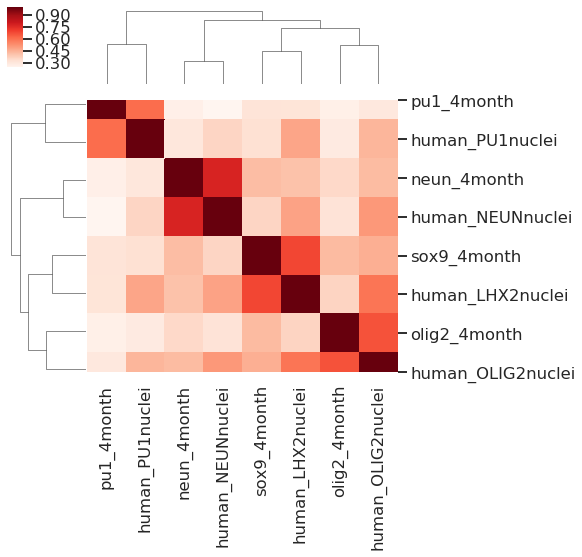

In [100]:
sns.clustermap(merge_df.corr('pearson'),
               cmap='Reds',
               square=True,
               figsize=(7,7))

# Get correlations across all samples
____
we will go with same strat as above and keep the highest average expression

In [122]:
mat['mean'] = mat.mean(1)
mat = mat.sort_values('mean', ascending=False)
mat = mat.drop(columns='mean')
# filter duplicates, keeping the first instance has highest average expression
mus_filt = mat.loc[~mat.index.duplicated(), :]
mus_filt.head()

,03_mouse_MPSIIIAhet_M_4mongh_Olig2,03_mouse_MPSIIIAhet_M_4month_Olig2,03_mouse_MPSIIIAhet_M_4month_Olig2,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,05_mouse_MPSIIIAhet_M_4month_PU1,05_mouse_MPSIIIAhet_M_4month_PU1,05_mouse_MPSIIIAhet_M_4month_PU1,03_mouse_MPSIIIAhet_M_4month_SOX9,03_mouse_MPSIIIAhet_M_4month_SOX9
Gene Name,,,,,,,,,,,,,
BRD2,1001.41,1156.18,968.71,1228.48,1122.49,1169.80,1084.68,712.83,1268.78,1059.55,956.77,721.63,1113.06
ZEB2,1369.36,1327.25,1003.94,672.65,615.92,666.16,648.84,508.36,1495.97,1408.96,1216.10,482.73,543.91
ZEB2OS,1342.58,1291.86,971.65,642.22,597.92,657.23,612.35,490.58,1515.89,1452.12,1179.25,470.75,548.00
JADE2,1208.67,1258.43,770.57,644.39,657.44,605.44,545.30,401.67,1696.58,1501.45,1307.54,380.55,539.81
ZFP532,1080.59,1092.28,681.03,1023.10,1075.43,1038.83,892.40,664.34,817.07,746.10,696.08,381.96,537.76


In [123]:
hum_mat['mean'] = hum_mat.mean(1)
hum_mat = hum_mat.sort_values('mean', ascending=False)
hum_mat = hum_mat.drop(columns='mean')
# filter duplicates, keeping the first instance has highest average expression
hum_filt = hum_mat.loc[~hum_mat.index.duplicated(), :]
hum_filt.head()

,/data/hg19/Nuclei/merged_tag_dir/human_LHX2nuclei_H3K27ac_epilepsy_pooled_hg19/,/data/hg19/Nuclei/merged_tag_dir/human_NEUNnuclei_H3K27ac_epilepsy_pooled_hg19/,/data/hg19/Nuclei/merged_tag_dir/human_OLIG2nuclei_H3K27ac_epilepsy_pooled_hg19/,/data/hg19/Nuclei/merged_tag_dir/human_PU1nuclei_H3K27ac_epilepsy_pooled_hg19/
Gene Name,,,,
QKI,1167.70,303.61,878.73,1821.66
BRD2,1088.55,584.18,871.81,1463.18
CAHM,1002.34,296.66,839.97,1787.96
TOB2,1459.14,475.03,883.25,985.77
PCBP1,867.94,598.24,892.84,1389.16


In [124]:
mat_merge = pd.merge(mus_filt,
                     hum_filt,
                     left_index=True,
                     right_index=True,
                     how='inner')

Now need to figure out how to extract the within cell comparisons and compare them to the other cell types 

In [125]:
mat_merge.corr()

,03_mouse_MPSIIIAhet_M_4mongh_Olig2,03_mouse_MPSIIIAhet_M_4month_Olig2,03_mouse_MPSIIIAhet_M_4month_Olig2,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,04_mouse_MPSIIIAhet_M_4month_NeuN,05_mouse_MPSIIIAhet_M_4month_PU1,05_mouse_MPSIIIAhet_M_4month_PU1,05_mouse_MPSIIIAhet_M_4month_PU1,03_mouse_MPSIIIAhet_M_4month_SOX9,03_mouse_MPSIIIAhet_M_4month_SOX9,/data/hg19/Nuclei/merged_tag_dir/human_LHX2nuclei_H3K27ac_epilepsy_pooled_hg19/,/data/hg19/Nuclei/merged_tag_dir/human_NEUNnuclei_H3K27ac_epilepsy_pooled_hg19/,/data/hg19/Nuclei/merged_tag_dir/human_OLIG2nuclei_H3K27ac_epilepsy_pooled_hg19/,/data/hg19/Nuclei/merged_tag_dir/human_PU1nuclei_H3K27ac_epilepsy_pooled_hg19/
03_mouse_MPSIIIAhet_M_4mongh_Olig2,1.000000,0.991183,0.978215,0.358869,0.355379,0.355172,0.344136,0.353030,0.272573,0.272269,0.259844,0.440848,0.426997,0.366049,0.324335,0.668772,0.293449
03_mouse_MPSIIIAhet_M_4month_Olig2,0.991183,1.000000,0.981442,0.357624,0.353239,0.353798,0.343802,0.352603,0.271746,0.271203,0.259906,0.442830,0.429970,0.367316,0.324101,0.669999,0.291892
03_mouse_MPSIIIAhet_M_4month_Olig2,0.978215,0.981442,1.000000,0.350030,0.345685,0.345875,0.337967,0.346307,0.257113,0.256618,0.246142,0.434239,0.422927,0.356308,0.318120,0.658457,0.276495
04_mouse_MPSIIIAhet_M_4month_NeuN,0.358869,0.357624,0.350030,1.000000,0.987149,0.987421,0.981098,0.959523,0.272981,0.273882,0.259084,0.439210,0.421496,0.421967,0.782823,0.431487,0.313029
04_mouse_MPSIIIAhet_M_4month_NeuN,0.355379,0.353239,0.345685,0.987149,1.000000,0.977813,0.973138,0.939183,0.272322,0.273721,0.258209,0.437533,0.419305,0.418640,0.783787,0.427766,0.310480
04_mouse_MPSIIIAhet_M_4month_NeuN,0.355172,0.353798,0.345875,0.987421,0.977813,1.000000,0.977211,0.969490,0.269390,0.270702,0.256127,0.432157,0.413808,0.408487,0.767969,0.422394,0.302257
04_mouse_MPSIIIAhet_M_4month_NeuN,0.344136,0.343802,0.337967,0.981098,0.973138,0.977211,1.000000,0.953964,0.258869,0.259703,0.246759,0.424500,0.407508,0.404023,0.769085,0.414575,0.295684
04_mouse_MPSIIIAhet_M_4month_NeuN,0.353030,0.352603,0.346307,0.959523,0.939183,0.969490,0.953964,1.000000,0.269972,0.270847,0.256559,0.437972,0.419185,0.408007,0.739584,0.419304,0.304508
05_mouse_MPSIIIAhet_M_4month_PU1,0.272573,0.271746,0.257113,0.272981,0.272322,0.269390,0.258869,0.269972,1.000000,0.989856,0.973704,0.327876,0.317541,0.317745,0.242709,0.304442,0.614536
05_mouse_MPSIIIAhet_M_4month_PU1,0.272269,0.271203,0.256618,0.273882,0.273721,0.270702,0.259703,0.270847,0.989856,1.000000,0.971789,0.331017,0.319897,0.318255,0.243870,0.303784,0.609149
